## Images of Dominoes: Image Segmentation Inference

Dataset Source: https://huggingface.co/datasets/adelavega/dominoes_raw

#### Import Necessary Libraries

In [1]:
import sys, random

import numpy as np
import matplotlib.pyplot as plt

import datasets
from datasets import load_dataset

from PIL import Image

import torch
from torch import nn

import transformers
from transformers import AutoModelForSemanticSegmentation
from transformers import AutoImageProcessor

import peft
from peft import PeftConfig, PeftModel

#### Display Library Versions

In [2]:
print("Python :".rjust(18), sys.version[0:6])
print("NumPy :".rjust(18), np.__version__)
print("Torch :".rjust(18), torch.__version__)
print("Transformers :".rjust(18), transformers.__version__)
print("Datasets :".rjust(18), datasets.__version__)
print("PEFT :".rjust(18), peft.__version__)

          Python : 3.9.12
           NumPy : 1.25.1
           Torch : 2.0.1
    Transformers : 4.26.1
        Datasets : 2.13.1
            PEFT : 0.3.0


#### Ingest Dataset

In [2]:
data = load_dataset("adelavega/dominoes_raw")

data = data.remove_columns(
    [
        'uuid', 
        'status',
        'label.annotations',
        'name'
    ]
)

data

Found cached dataset parquet (/Users/briandunn/.cache/huggingface/datasets/adelavega___parquet/adelavega--dominoes_raw-4d58def0d1b6754d/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label.segmentation_bitmap'],
        num_rows: 763
    })
})

#### Select Random Sample

In [3]:
random_idx = random.sample(range(len(data['train'])), 1)[0]

random_sample = data['train'][random_idx]

random_sample

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=448x448>,
 'label.segmentation_bitmap': <PIL.TiffImagePlugin.TiffImageFile image mode=I size=448x448>}

#### Display Sample Image

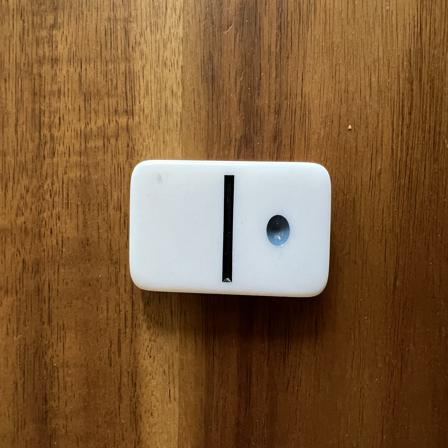

In [4]:
image = random_sample['image']

image

#### Create Conversions Between String & Integer Values For Label Values

In [5]:
id2label = {0: "domino", 1: "unlabeled"}
label2id = {label: idx for idx, label in id2label.items()}

unqiue_label_values = [id2label.values()]

NUM_OF_LABELS = len(unqiue_label_values)

print(f"List of Unique Label Values: {unqiue_label_values}")
print(f"Number of Unique Label Values: {NUM_OF_LABELS}")
print(f"label2id dictionary values: {label2id}")
print(f"id2label dictionary values: {id2label}")

List of Unique Label Values: [dict_values(['unlabeled', 'domino'])]
Number of Unique Label Values: 1
label2id dictionary values: {'unlabeled': 0, 'domino': 1}
id2label dictionary values: {0: 'unlabeled', 1: 'domino'}


#### Basic Values/Constants

In [6]:
MODEL_CKPT = "nvidia/mit-b0"
MODEL_NAME = "DunnBC22/mit-b0-Image_segmentation_Dominoes_v2"

#### Define Image Processor

In [7]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_CKPT, reduce_labels=False)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


#### Define Model

In [8]:
config = PeftConfig.from_pretrained(MODEL_NAME)
model = AutoModelForSemanticSegmentation.from_pretrained(
    MODEL_CKPT, 
    id2label=id2label, 
    label2id=label2id, 
    ignore_mismatched_sizes=True
)

inference_model = PeftModel.from_pretrained(model, MODEL_NAME)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_mean', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_

#### Encode Inference Image

In [9]:
encoding = image_processor(image.convert("RGB"), 
                           return_tensors="pt")

#### Run Inference With Encoded Image

In [10]:
with torch.no_grad():
    outputs = inference_model(pixel_values=encoding.pixel_values)
    logits = outputs.logits

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

#### Define Color Palette for Each Segment

In [24]:
def ade_palette():
    """
    Creates a label colormap that was originally 
    used in ADE20K segmentation benchmark.
    
    I changed the order of the different defined 
    colors and reduced the size of the array to 
    fit the need.

    Returns:
    A colormap for visualizing segmentation results.
    """
    return np.asarray([
        [4, 200, 3],
        [6, 230, 230],
        [120, 120, 120],
        [180, 120, 120],
        [80, 50, 50],
        [120, 120, 80],
    ])

#### Display Predicted Mask Over Original Image

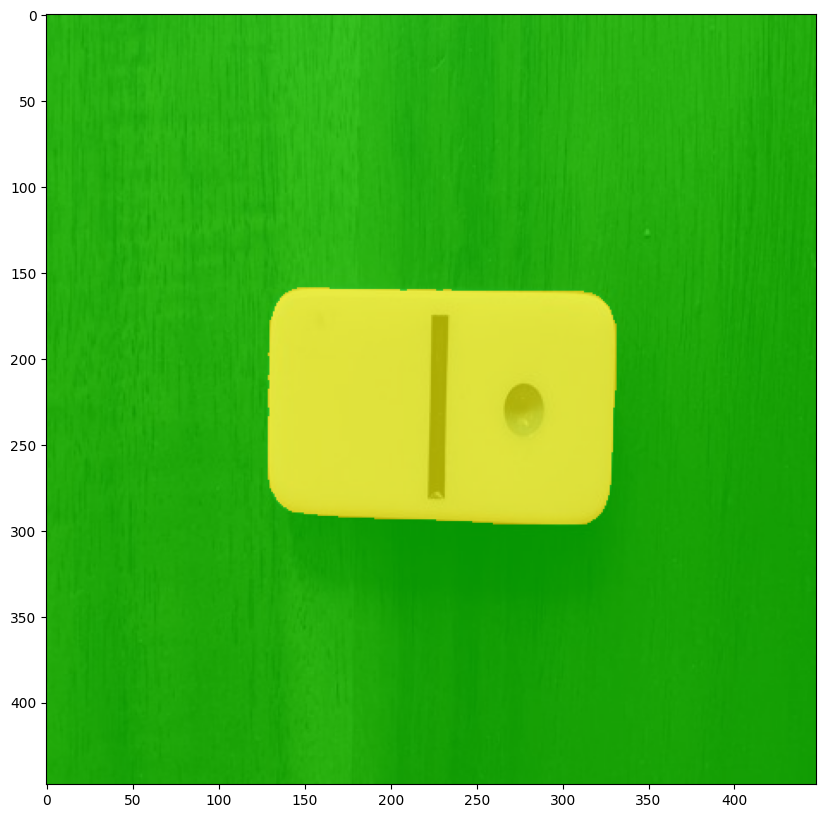

In [25]:
color_seg = np.zeros(
    (pred_seg.shape[0], 
     pred_seg.shape[1], 
     3
    ), 
    dtype=np.uint8)
palette = np.array(ade_palette())

for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

# display image with segmentation map
img = np.array(image) * 0.25 + color_seg * 0.75 
img = img.astype(np.uint8)

plt.figure(figsize=
           (
               15, 
               10
            )
        )
plt.imshow(img)
plt.show()

#### Special Thanks

- For the premade 'ade_palette' for colors to apply predicted mask over original image. (I did modify the array by shuffling the order and reducing the size of the array)
    > https://github.com/tensorflow/models/blob/3f1ca33afe3c1631b733ea7e40c294273b9e406d/research/deeplab/utils/get_dataset_colormap.py#L51
